In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Method 1 (Modifying Code from Homework 5)
### Train Model

In [37]:
# Create m x n matrix for Y
Y_train = np.loadtxt('./data/train_cleaned.txt').astype(int)
Y_test = np.loadtxt('./data/test_cleaned.txt').astype(int)

In [ ]:
def grad_U(Ui, Yij, Vj, reg, eta):
    return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj)))

def grad_V(Ui, Yij, Vj, reg, eta):
    return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj)))

def get_err(U, V, Y, reg=0.0):
    err = 0
    for x in range(Y.shape[0]):
        i = Y[x][0] - 1
        j = Y[x][1] - 1
        err += pow(Y[x][2] - np.dot(U[i,:], V[j,:]), 2)    
    return 1 / Y.shape[0] * ((reg * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2) + err) / 2) 

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    U = np.random.uniform(-0.5, 0.5, size=(M, K))
    V = np.random.uniform(-0.5, 0.5, size=(N, K))
    loss = []
    loss.append(get_err(U, V, Y, reg))
    
    for epoch in range(max_epochs): 
        index = np.random.permutation(Y.shape[0])
        for idx in index:
            i = Y[idx][0] - 1
            j = Y[idx][1] - 1
            
            u = grad_U(U[i,:], Y[idx][2], V[j,:], reg, eta)
            v = grad_V(U[i,:], Y[idx][2], V[j,:], reg, eta)
            U[i,:] -= u
            V[j,:] -= v 
        err = get_err(U, V, Y, reg)
        loss.append(err)
        if (abs(loss[-1] - loss[-2]) / abs(loss[1] - loss[0]) < eps):
            break
    
    err = get_err(U, V, Y)
    return (U, V, err)

In [22]:
# Create 943 users x 1682 movies 
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

k = 20
reg = 0.0
eta = 0.03 # learning rate

# Train model with no regularization
U, V, E_in = train_model(M, N, k, eta, reg, Y_train)
E_out = get_err(U, V, Y_test)

print("Training error is: " + str(E_in))
print("Test error is: " + str(E_out))

Factorizing with  943  users,  1682  movies.
Training error is: 0.20168443075353984
Test error is: 0.5736250926936307


### Test Regularization Strengths

In [53]:
# Test various values of regularization to reduce overfitting
test_reg = [10**-3, 10**-2, 10**-1, 1]

for r in test_reg:
    U_reg, V_reg, E_in_reg = train_model(M, N, k, eta, r, Y_train)
    E_out_reg = get_err(U_reg, V_reg, Y_test)
    print('Regularization = %.4f: \nTraining error is %.4f and Test error is %.4f' % (r, E_in_reg, E_out_reg))

Regularization = 0.0010: 
Training error is 0.1885 and Test error is 0.5985
Regularization = 0.0100: 
Training error is 0.1969 and Test error is 0.5625
Regularization = 0.1000: 
Training error is 0.3089 and Test error is 0.4456
Regularization = 1.0000: 
Training error is 0.9482 and Test error is 0.9676


In [26]:
# Train model with best regularization chosen from testing various strengths
reg = 0.1

U, V, E_in = train_model(M, N, k, eta, reg, Y_train)
E_out = get_err(U, V, Y_test)

print("Training error is: " + str(E_in))
print("Test error is: " + str(E_out))

Training error is: 0.2881364119509543
Test error is: 0.44127980746840495


## Visualize and Interpret Results

In [43]:
# Visualize and interpret results
def visualize(U, V):
    ''' 
        U (k x M)
        V (k x N)
    '''
    A, sigma, B = np.linalg.svd(V)
    U_tilde = np.matmul(np.transpose(A[:,:2]), U)
    V_tilde = np.matmul(np.transpose(A[:,:2]), V)
    return U_tilde, V_tilde
    
U_tilde, V_tilde = visualize(np.transpose(U), np.transpose(V))

In [44]:
colnames = ['movie_id', 'title', 'unknown', "action", "adventure", "animation", 
            "childrens", "comedy", "crime", "documentary", "drama", "fantasy", 
            "film-noir", "horror", "musical", "mystery", "romance", "sci-fi", 
            "thriller", "war", "western"]
movie_info = pd.read_csv("data/movies.txt", names=colnames, sep='\t', header=None)

movie_to_genre = dict()

for index, row in movie_info.iterrows():
    if row['title'] not in movie_to_genre:
        movie_to_genre[row['title']] = row['unknown':'western'].to_numpy()

id_to_movie_title = movie_info['title'].tolist()
id_to_movie_title.insert(0, "NO MOVIE WITH ID 0")

movie_to_id = dict()

for i in range(1,len(id_to_movie_title)):
    if (id_to_movie_title[i] not in movie_to_id):
        movie_to_id[id_to_movie_title[i]] = i        

### Plot 10 Movies from Entire Dataset

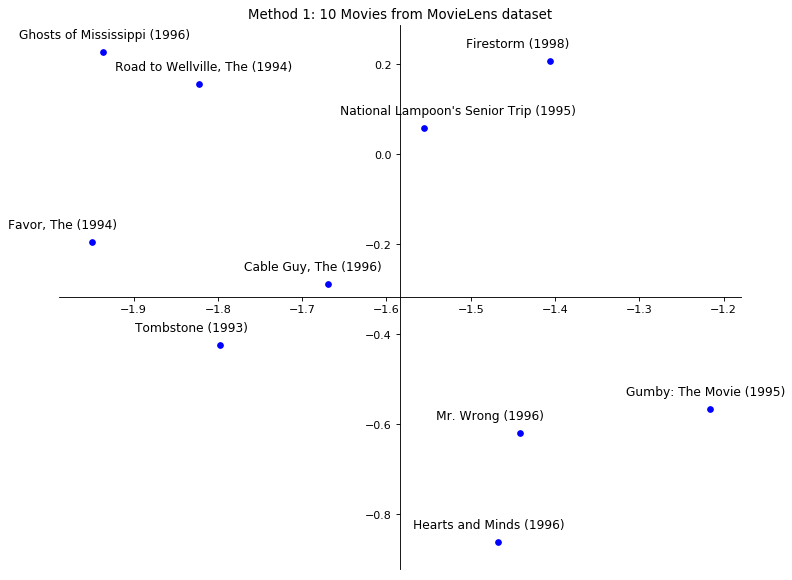

In [46]:
np.random.seed(42)
movies = np.random.choice(list(movie_to_genre.keys()), 10)
movie_ids = [movie_to_id[m] for m in movies]

# ====================== TEN CHOSEN MOVIES PLOT ======================
V_ten = np.take(np.transpose(V_tilde), movie_ids, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_ten)):
    x = V_ten[i][0]
    y = V_ten[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, movies[i], fontsize=11)
plt.title('Method 1: 10 Movies from MovieLens dataset')
plt.show()

### Plot 10 Most Popular Movies

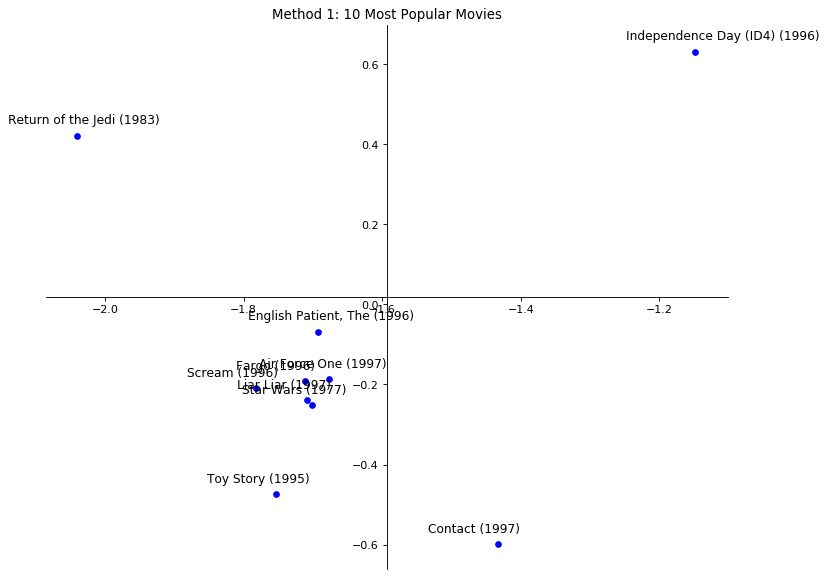

In [48]:
popular_movies = ['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 
                  'Return of the Jedi (1983)', 'Liar Liar (1997)', 
                  'English Patient, The (1996)', 'Scream (1996)', 
                  'Toy Story (1995)', 'Air Force One (1997)', 
                  'Independence Day (ID4) (1996)']
pop_movies_id = [movie_to_id[m] for m in popular_movies]

# ====================== TEN MOST POPULAR MOVIES PLOT ======================
V_pop = np.take(np.transpose(V_tilde), pop_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_pop)):
    x = V_pop[i][0]
    y = V_pop[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, popular_movies[i], fontsize=11)
plt.title('Method 1: 10 Most Popular Movies')
plt.show()

### Plot 10 Best Movies

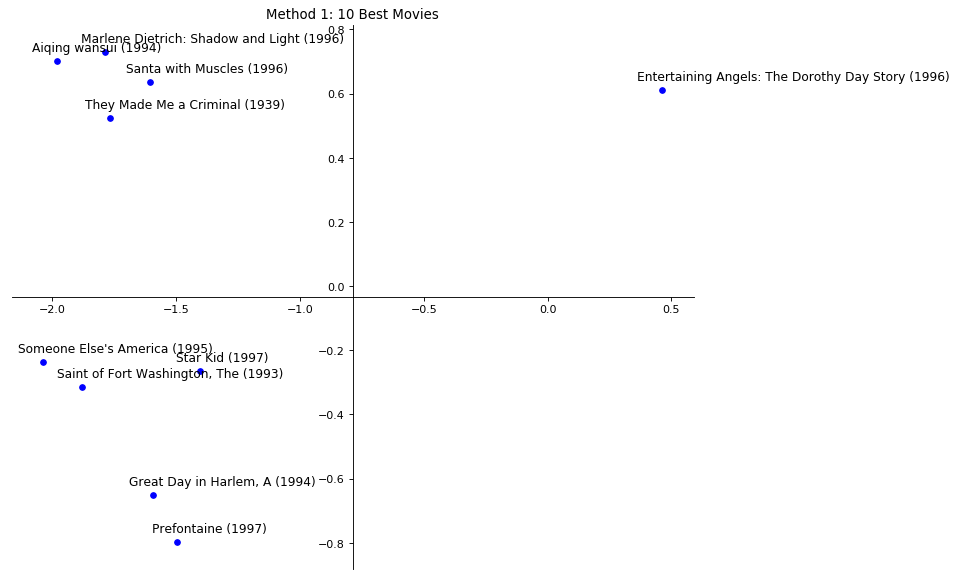

In [49]:
best_movies = ['Prefontaine (1997)', 'Santa with Muscles (1996)', 
               'Great Day in Harlem, A (1994)', 'Aiqing wansui (1994)', 
               'Star Kid (1997)', "Someone Else's America (1995)", 
               'Entertaining Angels: The Dorothy Day Story (1996)', 
               'Saint of Fort Washington, The (1993)', 
               'They Made Me a Criminal (1939)', 
               'Marlene Dietrich: Shadow and Light (1996) ']

best_movies_id = [movie_to_id[m] for m in best_movies]

# ====================== TEN BEST MOVIES PLOT ======================
V_best = np.take(np.transpose(V_tilde), best_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_best)):
    x = V_best[i][0]
    y = V_best[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, best_movies[i], fontsize=11)
plt.title('Method 1: 10 Best Movies')
plt.show()

### Plot 10 Movies from 3 Genres

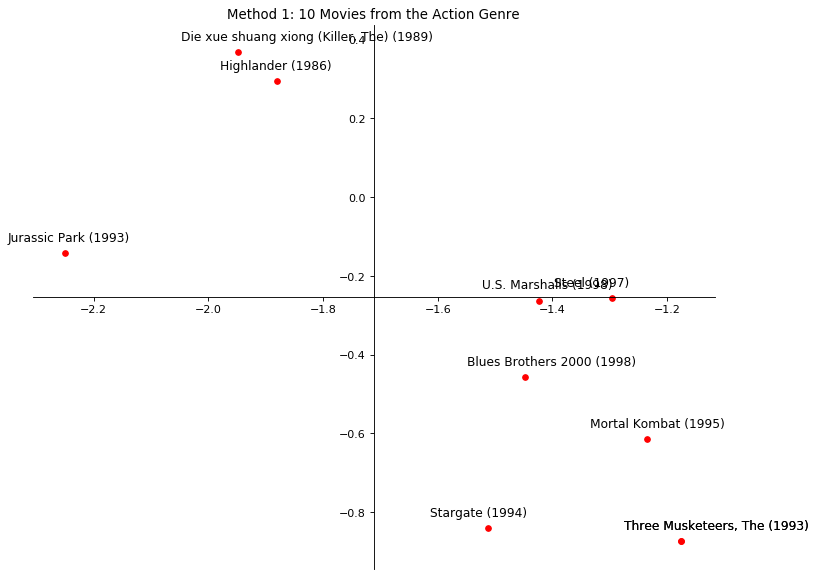

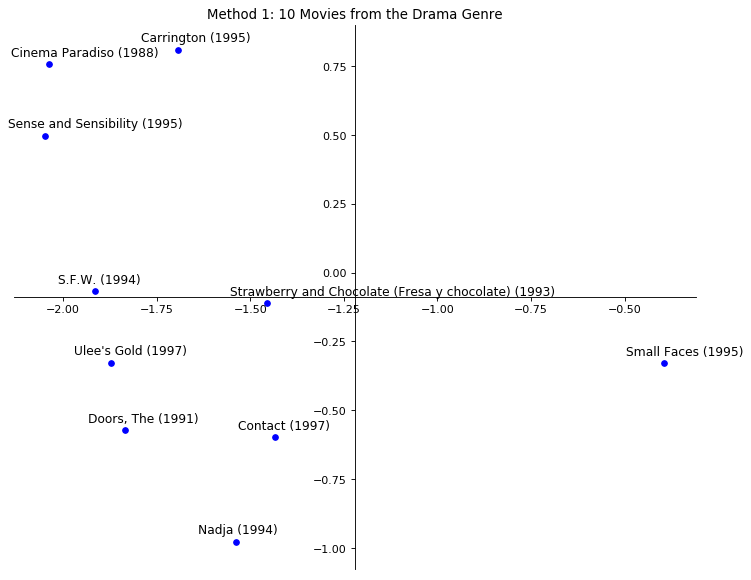

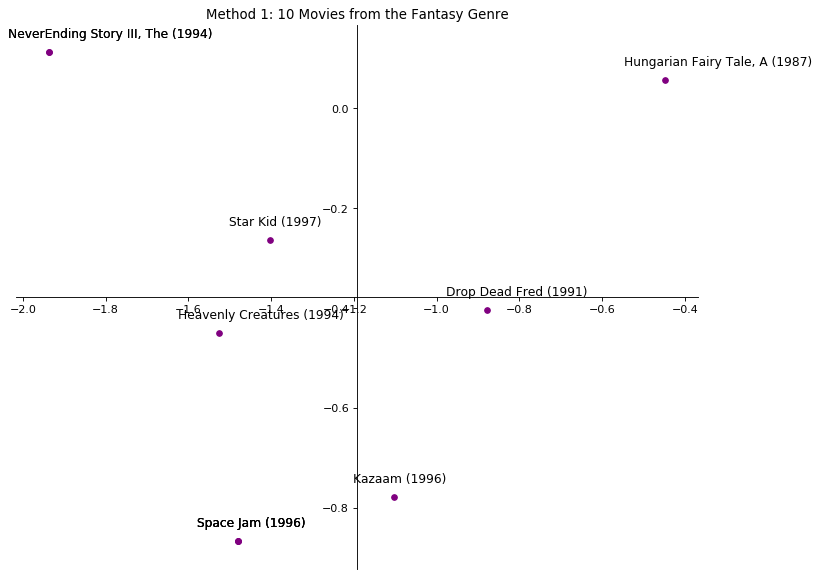

In [52]:
action = []
drama = []
fantasy = []

for key, val in movie_to_genre.items():
    if val[1]:
        action.append(key)
    if val[8]:
        drama.append(key)
    if val[9]:
        fantasy.append(key)
        
np.random.seed(42)       
action = np.random.choice(action, 10)
action_id = [movie_to_id[m] for m in action]

np.random.seed(42)
drama = np.random.choice(drama, 10)
drama_id = [movie_to_id[m] for m in drama]

np.random.seed(42)
fantasy = np.random.choice(fantasy, 10)
fantasy_id = [movie_to_id[m] for m in fantasy]

# ====================== TEN MOVIES FROM EACH OF THE THREE GENRES PLOT ======================

# ACTION GENRE
V_action = np.take(np.transpose(V_tilde), action_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_action)):
    x = V_action[i][0]
    y = V_action[i][1]
    plt.scatter(x, y, marker='.', color='red', s=100)
    plt.text(x - 0.1, y + 0.03, action[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Action Genre')
plt.show()

# DRAMA GENRE
V_drama = np.take(np.transpose(V_tilde), drama_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_drama)):
    x = V_drama[i][0]
    y = V_drama[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, drama[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Drama Genre')
plt.show()

# FANTASY GENRE
V_fantasy = np.take(np.transpose(V_tilde), fantasy_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_fantasy)):
    x = V_fantasy[i][0]
    y = V_fantasy[i][1]
    plt.scatter(x, y, marker='.', color='purple', s=100)
    plt.text(x - 0.1, y + 0.03, fantasy[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Fantasy Genre')
plt.show()